In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
from scipy.stats import pearsonr
import yfinance as yf

# 1. 2018, 2019, 2020년도 H&M 연간보고서에서 추출한 데이터로 대륙별 매출 및 상점 수 분석

## [데이터]

### hmGlobalSalesData => H&M 글로벌 마켓 나라별 연도별 오프라인 마켓수와 매출

In [2]:
hmGlobalSalesData = pd.read_csv('hmNetSaleByMarket.csv')
hmGlobalSalesData.head(3)

,market,continent,market_with_online_2018,sales_sekM_2018,sales_percentage_2018,sales_rank_2018,store_number_2018,market_with_online_2019,sales_sekM_2019,sales_percentage_2019,sales_rank_2019,store_number_2019,market_with_online_2020,sales_sekM_2020,sales_percentage_2020,sales_rank_2020,store_number_2020
0,Germany,Europe,1,32367,15.38%,1,468,1,33540,14.41%,1,466,1,29684,15.87%,1,457
1,USA,North America,1,24798,11.79%,2,578,1,29976,12.88%,2,593,1,20802,11.12%,2,582
2,UK,Europe,1,13760,6.54%,3,304,1,14897,6.40%,3,305,1,11486,6.14%,3,289


### * 이 데이터의 아쉬운 점은 H&M 그룹이 갖고 있는 브랜드별 매출과 매장 수가 따로 나누어지지 않아서 브랜드별 추이는 알수 없다.
### * 먼저 데이터를 연도별로 나누어서 세개의 데이터를 활용해서 살펴보았다.

## [데이터 전처리] 각 연도별로 데이터 나누기

In [3]:
salesData2018 = hmGlobalSalesData[['market', 'continent', 'market_with_online_2018', 'sales_sekM_2018',
                                   'sales_percentage_2018', 'sales_rank_2018', 'store_number_2018']]
salesData2019 = hmGlobalSalesData[['market', 'continent', 'market_with_online_2019', 'sales_sekM_2019', 
                                   'sales_percentage_2019','sales_rank_2019', 'store_number_2019',]]
salesData2020 = hmGlobalSalesData[['market', 'continent', 'market_with_online_2020','sales_sekM_2020', 
                                   'sales_percentage_2020', 'sales_rank_2020','store_number_2020']]

## [그래프] 2018년과 2019년 H&M 대륙별 실제 상점 수

Text(0, 0.5, 'Store Numebrs')

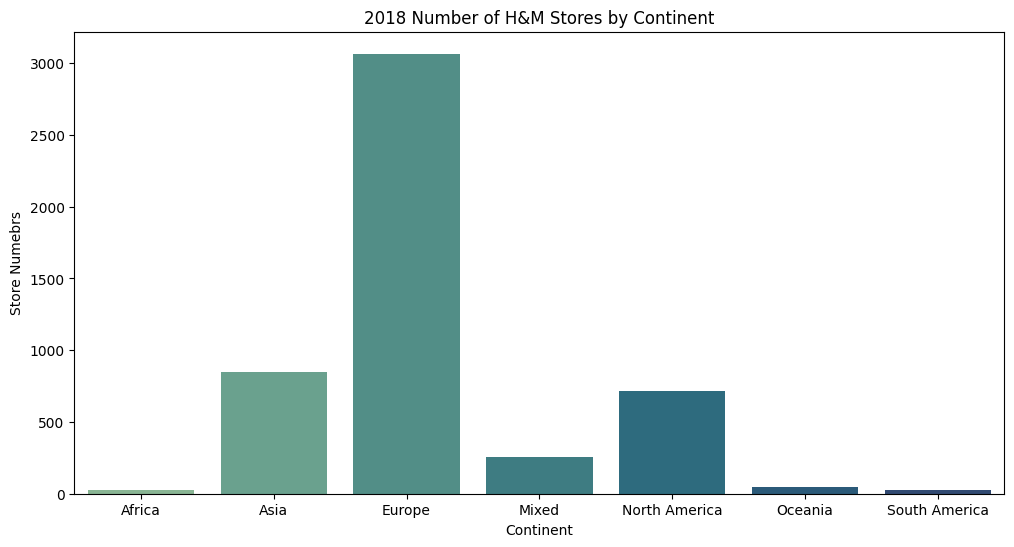

In [4]:
temp2018 = salesData2018.groupby(by='continent')['store_number_2018'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=temp2018, x='continent', y='store_number_2018', palette="crest")
plt.title('2018 Number of H&M Stores by Continent')
plt.xlabel('Continent')
plt.ylabel('Store Numebrs')

Text(0, 0.5, 'Store Numebrs')

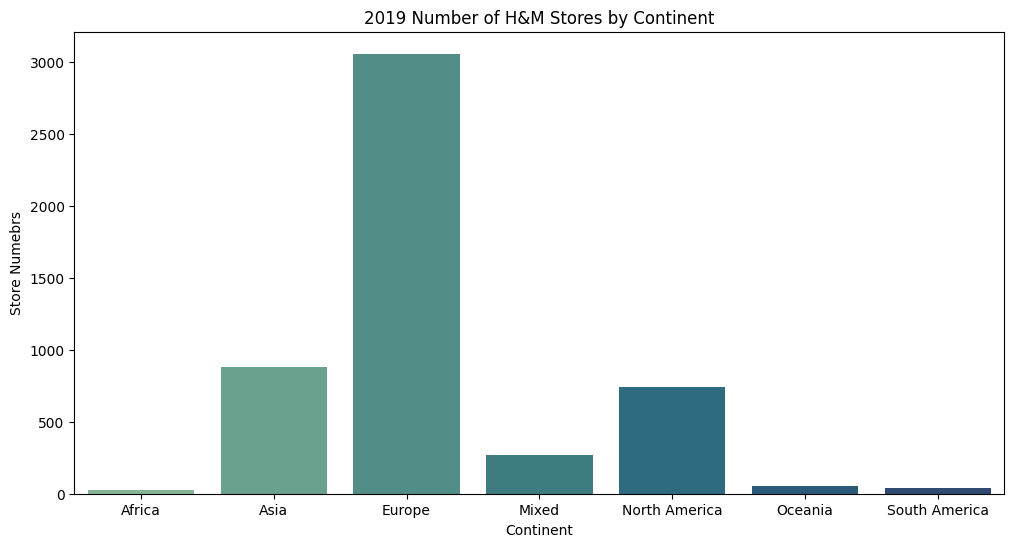

In [5]:
temp2019 = salesData2019.groupby(by='continent')['store_number_2019'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=temp2019, x='continent', y='store_number_2019', palette="crest")
plt.title('2019 Number of H&M Stores by Continent')
plt.xlabel('Continent')
plt.ylabel('Store Numebrs')

### * 유럽의 상점 수가 압도적으로 많다 
### * 하지만 위의 두 바 차트로 봤을 때 연도별 변화를 확인하기가 어렵다.
### * 그래서 연도별 테이블의 컬럼 명을 다 똑같이 바꾸고 나서 concat을 통해 테이블을 병합해야겠다. 

## [데이터 전처리] 테이블 concat

In [6]:
salesData2018.columns = ['market', 'continent', 'market_with_online', 'sales_sekM', 'sales_percentage', 'sales_rank', 'store_number']
salesData2018.insert(0, "year", "2018")
salesData2019.columns = ['market', 'continent', 'market_with_online', 'sales_sekM', 'sales_percentage', 'sales_rank', 'store_number']
salesData2019.insert(0, "year", "2019")
salesData2020.columns = ['market', 'continent', 'market_with_online', 'sales_sekM', 'sales_percentage', 'sales_rank', 'store_number']
salesData2020.insert(0, "year", "2020")
concatSalesData = pd.concat([salesData2018, salesData2019, salesData2020]) 
concatSalesData['year'] = pd.to_datetime(concatSalesData['year']).dt.year
concatSalesData.head(3)

,year,market,continent,market_with_online,sales_sekM,sales_percentage,sales_rank,store_number
0,2018,Germany,Europe,1,32367,15.38%,1,468
1,2018,USA,North America,1,24798,11.79%,2,578
2,2018,UK,Europe,1,13760,6.54%,3,304


## [그래프] 연도별 H&M 매출

Text(0, 0.5, 'Sales (Unit: SEK Million)')

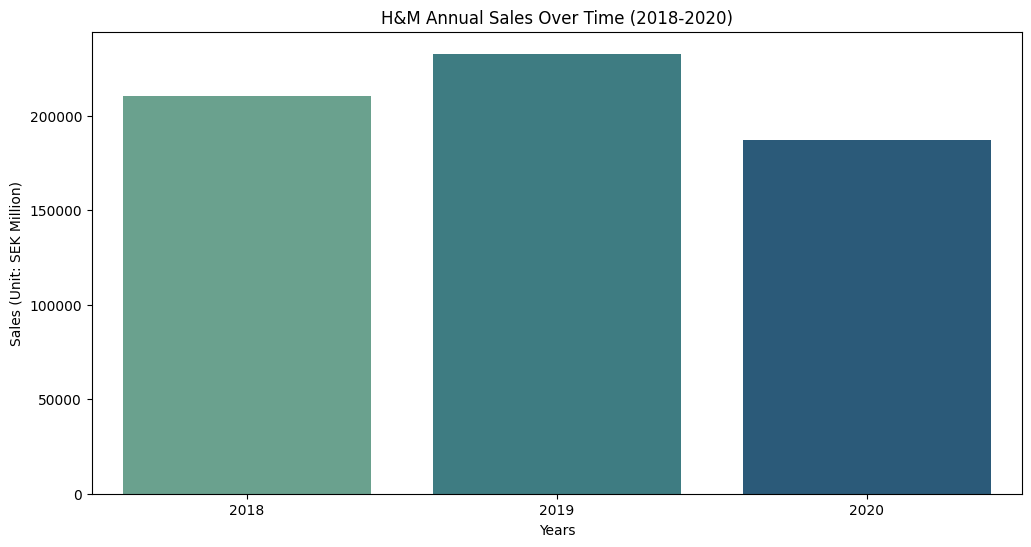

In [7]:
totalSales = concatSalesData.groupby(by=['year'])['sales_sekM'].sum().reset_index(name='sales_sekM')
plt.figure(figsize=(12, 6))
sns.barplot(data=totalSales, x='year', y='sales_sekM',  palette="crest")
plt.title('H&M Annual Sales Over Time (2018-2020)')
plt.xlabel('Years')
plt.ylabel('Sales (Unit: SEK Million)')

## [그래프] 연도별 대륙별 H&M 매출, 상점 수, 온라인 채널 수

Text(0, 0.5, 'Sales (Unit: SEK Million)')

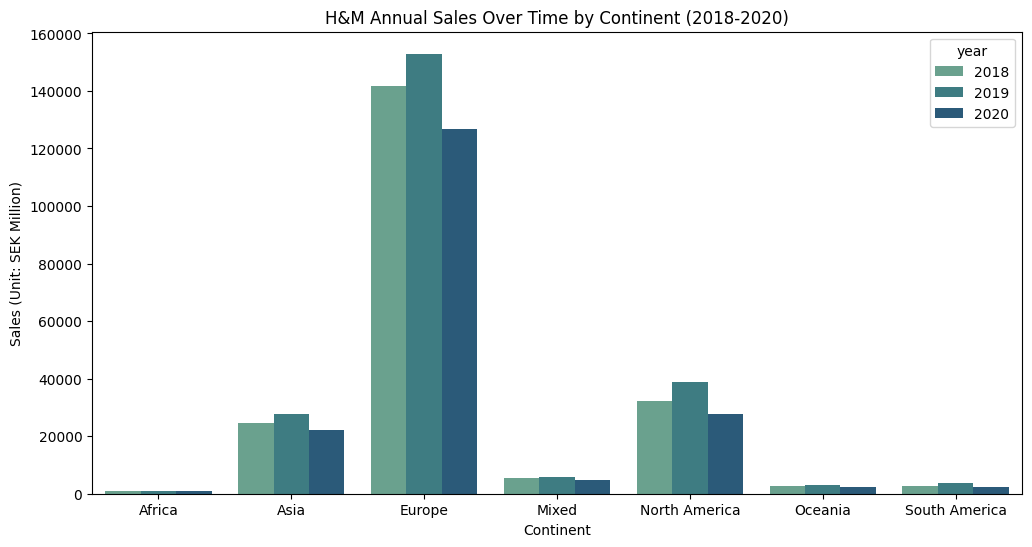

In [8]:
totalSales = concatSalesData.groupby(by=['year','continent'])['sales_sekM'].sum().reset_index(name='sales_sekM')
plt.figure(figsize=(12, 6))
sns.barplot(data=totalSales, x='continent', y='sales_sekM', hue='year',  palette="crest")
plt.title('H&M Annual Sales Over Time by Continent (2018-2020)')
plt.xlabel('Continent')
plt.ylabel('Sales (Unit: SEK Million)')

### * 모든 대륙에서 매출이 18년도에서 19년도에는 상승을 했지만 20년도에 하락했다.
### * 이것을 통해 어떠한 이유로 인한 매출 하락인지 살펴봐야 할 것이다.

Text(0, 0.5, 'Store Number')

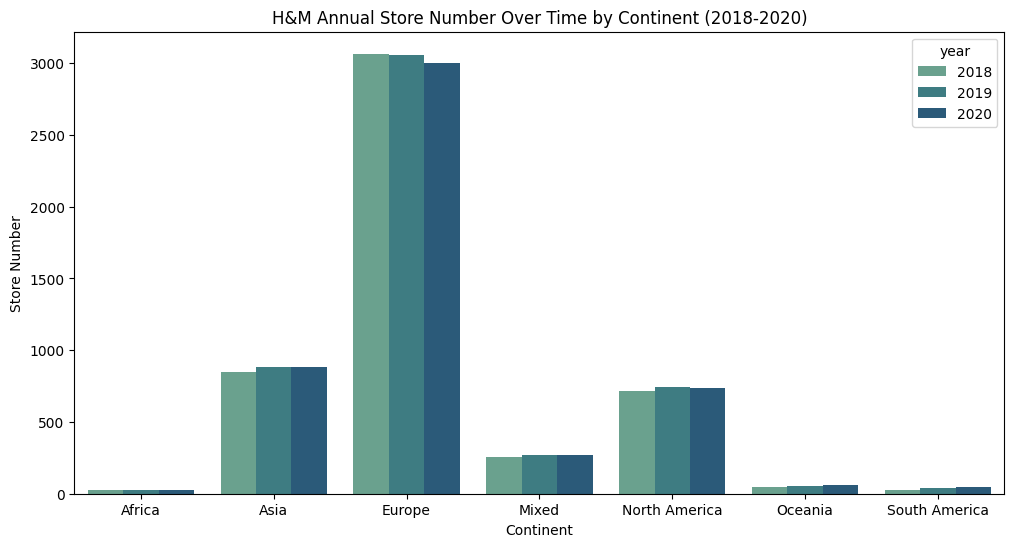

In [9]:
totalStore = concatSalesData.groupby(by=['year','continent'])['store_number'].sum().reset_index(name='store_number')
plt.figure(figsize=(12, 6))
sns.barplot(data=totalStore, x='continent', y='store_number', hue='year',  palette="crest")
plt.title('H&M Annual Store Number Over Time by Continent (2018-2020)')
plt.xlabel('Continent')
plt.ylabel('Store Number')

### * 대륙별로 상점 수가 많으면 그에 상응하는 매출이 있다는 것을 확인할 수 있었다.
### * 예외로 단순 상점 숫자를 비교 했을 때는 아시아가 북아메리카보다 더 많지만 매출을 북아메리카가 더 높다.
### * 북아메리카 소비자들은 실제 매장에서 구매하기 보다는 온라인 매장을 선호해서 매장 수가 적어도 매출이 높은 것 일까?

Text(0, 0.5, 'Online Store Number')

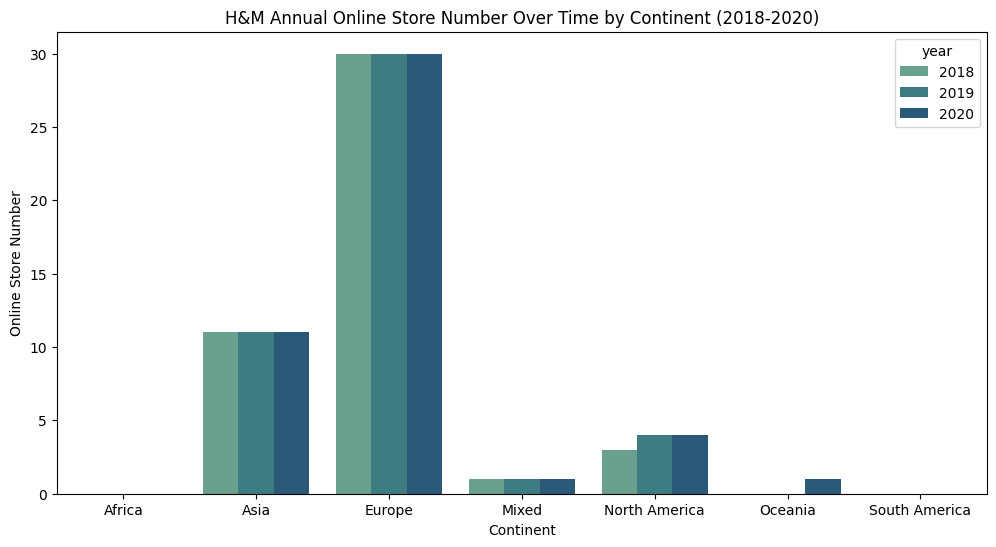

In [10]:
totalOnline = concatSalesData.groupby(by=['year','continent'])['market_with_online'].sum().reset_index(name='online_store_number')
plt.figure(figsize=(12, 6))
sns.barplot(data=totalOnline, x='continent', y='online_store_number', hue='year',  palette="crest")
plt.title('H&M Annual Online Store Number Over Time by Continent (2018-2020)')
plt.xlabel('Continent')
plt.ylabel('Online Store Number')

### * 이를 통해 실제 매장 수와 온라인 매장 수가 아시아가 북아메리카보다 더 많지만 매출은 북아메리카가 더 높다는 것을 확인할 수 있다.
### * 북아메리카 소비자들이 아시아 소비자들보다 H&M 브랜드를 더 선호하거나 더 값이 나가는 물건을 구입해서 그런것 같다.
### * 한가지 확실한 것은 H&M은 유럽에 가장 많은 실제 매장과 온라인 채널이 존재하고 유럽에서 매출이 가장 많다.
### * 유럽 다음으로 매출이 많은 시장은 북아메리카다.

# 2. H&M의 연별 월별 매출 및 구매자 분석

## 파트 1에서 H&M 연간보고서를 통해 2018년에서 2019년도에는 매출이 상승을 했지만 2020년에는 하락한 것을 볼 수 있었다. 케글에서 구한 데이터가 연간보고서의 추세와 같은 추세를 따르는지 확인해 보아야한다. 만약 케글 데이터의 추세가 연간보고서의 추세와 같다면 이 데이터를 신뢰할 수 있다. 하지만 2018년도에는 9월부터 12월까지의 데이터가 존재하고 2020년도에는 1월부터 9월까지의 데이터 밖에 없어서 연도별로 분석하기에는 어려움이 있다. 그래서 월별 매출을 연도별로 다른 색으로 놓고 그래프를 그려보았다. 

## [데이터]

### transaction => 주문 건 정보

In [11]:
transaction = pd.read_csv("transactions_train.csv")
transaction.head(3)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2


### customer => 고객 정보

In [12]:
customer = pd.read_csv("customers.csv")
customer.head(3)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...


### article => 상품 정보

In [13]:
article = pd.read_csv("articles.csv")
article.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


## [데이터 전처리] 연도별 월별 일별 분석을 위해 연, 월, 일, 컬럼 만들어주기

In [14]:
transaction['t_dat'] = pd.to_datetime(transaction['t_dat'])
years = transaction['t_dat'].dt.year
months = transaction['t_dat'].dt.month
days = transaction['t_dat'].dt.day
transaction.insert(1, "Years", years)
transaction.insert(2, "Months", months)
transaction.insert(3, "Days", days)
transaction.head(3)

,t_dat,Years,Months,Days,customer_id,article_id,price,sales_channel_id
0,2018-09-20,2018,9,20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,2018,9,20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,2018,9,20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2


## [데이터 전처리] H&M transaction로 시간별 매출과 상품별 판매 건수를 알기 위해 테이블에 article 테이블 컬럼 더하기

In [15]:
transactionWithName = transaction.copy()

In [16]:
transactionWithName = transactionWithName.merge(article[['article_id', 'prod_name', 'product_type_name', 'index_group_name', 'garment_group_name']],
                               on='article_id', 
                               how='left')

In [17]:
index_group_name = transactionWithName['index_group_name']
garment_group_name = transactionWithName['garment_group_name']
product_type_name = transactionWithName['product_type_name']
prod_name = transactionWithName['prod_name']
del transactionWithName['index_group_name']
del transactionWithName['garment_group_name']
del transactionWithName['product_type_name']
del transactionWithName['prod_name']
transactionWithName.insert(8, 'index_group_name', index_group_name)
transactionWithName.insert(9, 'garment_group_name', garment_group_name)
transactionWithName.insert(10, 'product_type_name', product_type_name)
transactionWithName.insert(11, 'prod_name', prod_name)
transactionWithName.head(3)

,t_dat,Years,Months,Days,customer_id,article_id,price,sales_channel_id,index_group_name,garment_group_name,product_type_name,prod_name
0,2018-09-20,2018,9,20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,Ladieswear,"Under-, Nightwear",Underwear body,Atlanta Push Body Harlow
1,2018-09-20,2018,9,20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,Ladieswear,"Under-, Nightwear",Bra,Rae Push (Melbourne) 2p
2,2018-09-20,2018,9,20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,Divided,Knitwear,Sweater,Inca Jumper


## [그래프] 월별 매출 추이

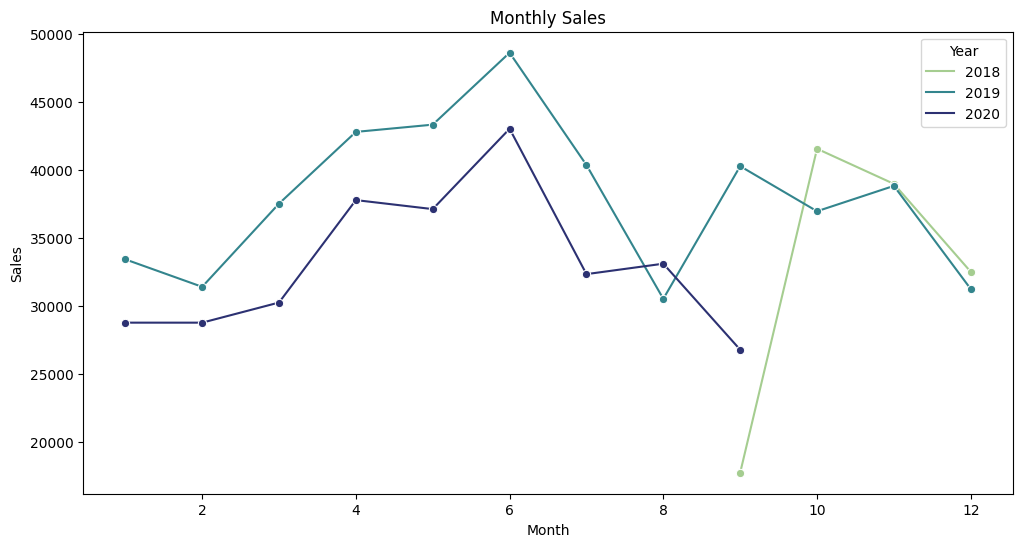

In [18]:
yearMonthSales = transactionWithName.groupby(['Years', 'Months'])['price'].sum().reset_index(name='sales')
yearMonthSales['Months'] = yearMonthSales['Months'].astype(int)
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearMonthSales, x='Months', y='sales', hue='Years', marker='o', palette="crest")
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(title='Year')
plt.show()

### * 그래프를 보았을 때 10월부터 12월까지의 데이터로만 2018년도에서 2019년도에 매출이 증가했다고 보기는 어렵지만 2019년 대비 2020년에는 매출이 하락한 것을 확인할 수 있었다.
### * 그러므로 케글 데이터를 어느 정도 신뢰할 수 있다고 판단했다.
### * 2019년과 2020년 데이터를 통해서 2월부터 6월까지는 매출이 상승하는것을 확인할 수 있고 6월을 기점으로 매출이 8월까지 하락하는 것을 확인할 수 있다.
### * 이러한 현상이 생긴 이유는 주문 고객 수가 증가함과 하락함에 있다고 보아서 월별 구매자 수도 함께 보았다.

## [그래프] 월별 구매자 수 추이

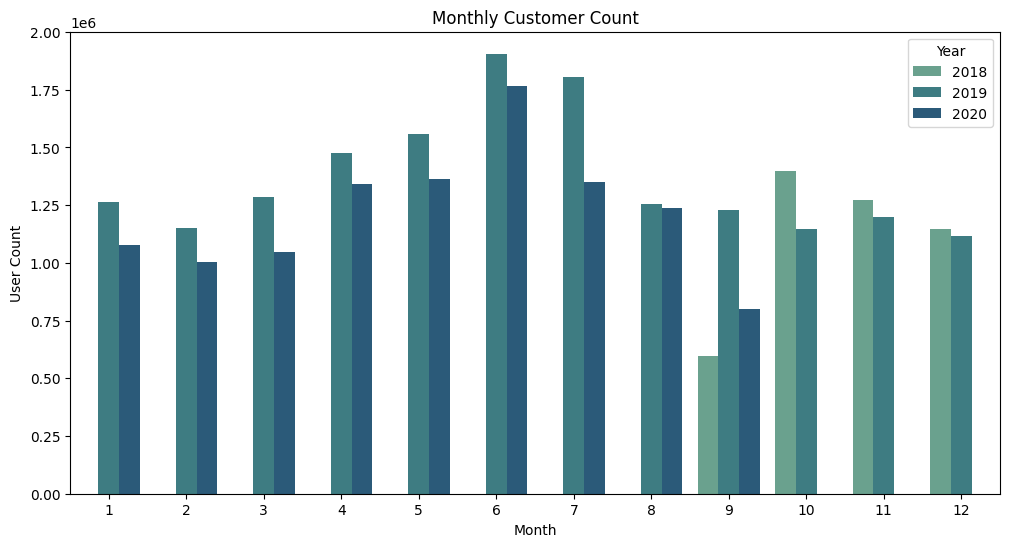

In [19]:
userCounts = transactionWithName.groupby(['Years', 'Months'])['customer_id'].count().reset_index(name='userCount')
userCounts['Months'] = userCounts['Months'].astype(int)
plt.figure(figsize=(12, 6))
sns.barplot(data=userCounts, x='Months', y='userCount', hue='Years', palette="crest")
plt.title('Monthly Customer Count')
plt.xlabel('Month')
plt.ylabel('User Count')
plt.legend(title='Year')
plt.show()

### * 구매자 수와 매출은 양의 상관 관계를 갖고 있는 것을 확인 할 수 있었다.
### * 하지만 2019년도 9월과 2020년 8월은 전월 대비 구매자 수가 줄어 들었지만 매출은 상승한 것을 볼 수 있다.
### * 이것을 파악하기 위해 해당 월의 매출과 주문자 수를 자세하게 살펴보았다.

## [데이터 전처리] 2019년 9월과 2020년 8월 데이터 추출하기

In [20]:
trans2019 = transactionWithName[(transactionWithName['t_dat']>'2019-08-31')&(transactionWithName['t_dat']<'2019-10-01')]
trans2020 = transactionWithName[(transactionWithName['t_dat']>'2020-07-31')&(transactionWithName['t_dat']<'2020-09-01')]
trans2019.head(3)

,t_dat,Years,Months,Days,customer_id,article_id,price,sales_channel_id,index_group_name,garment_group_name,product_type_name,prod_name
16117894,2019-09-01,2019,9,1,000f7535bdc611ad136a9f04746d6b1431f50a7f60fbbe...,727880001,0.016932,1,Ladieswear,Shoes,Sneakers,Mimmi new
16117895,2019-09-01,2019,9,1,000f7535bdc611ad136a9f04746d6b1431f50a7f60fbbe...,767869001,0.008458,1,Ladieswear,Jersey Basic,Vest top,V-neck Strap Top.
16117896,2019-09-01,2019,9,1,000f7535bdc611ad136a9f04746d6b1431f50a7f60fbbe...,717490010,0.008458,1,Divided,Jersey Basic,T-shirt,Cat Tee.


## [그래프] 2019년 9월 매출과 구매자 수

Text(0.5, 1.0, 'Daily Sales and Customer Count in 2019 September')

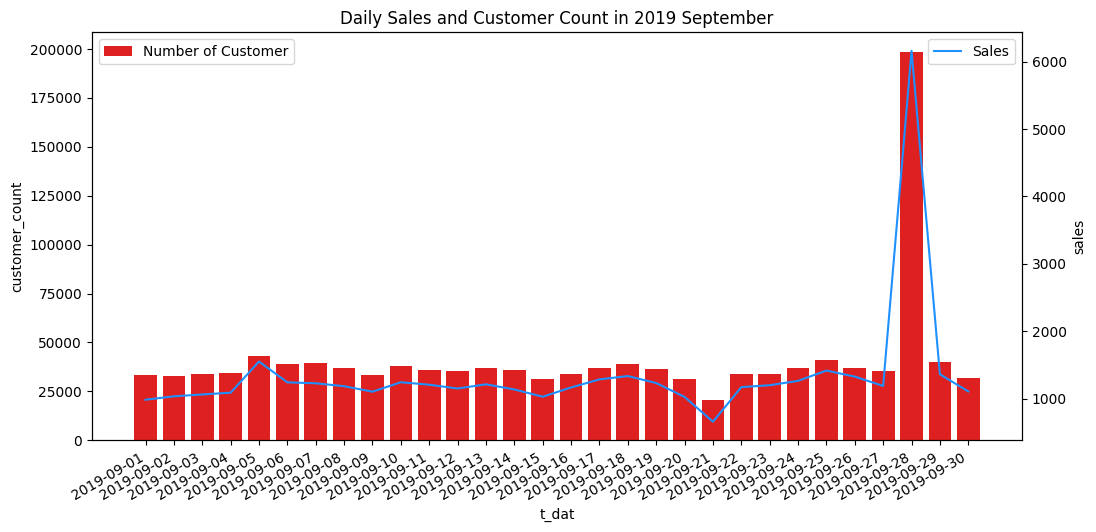

In [21]:
saleSum2019 = trans2019.groupby(by=['t_dat'])['price'].sum().reset_index(name='sales')
custCount2019 = trans2019.groupby(by=['t_dat'])['customer_id'].count().reset_index(name='customer_count')
saleCust2019 = saleSum2019.merge(custCount2019, on='t_dat', how='left')
fig, ax = plt.subplots(figsize=(12, 6))
p1 = sns.barplot(ax=ax, x='t_dat', y='customer_count', data=saleCust2019, color='red', label='Number of Customer')
ax2 = ax.twinx()
p2 = sns.lineplot(ax=ax2, x=ax.get_xticks(), y='sales', data=saleCust2019, color='dodgerblue', label = 'Sales')
date_range = pd.date_range(start='2019-09-01', end='2019-09-30', freq='D')
date_labels = [date.strftime('%Y-%m-%d') for date in date_range]
plt.xticks(range(30), date_labels)
plt.gcf().autofmt_xdate()
p1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Daily Sales and Customer Count in 2019 September')

### * 확인 결과 9월 28일에 매출과 구매자 수 모두 높은 것을 알 수 있었다.
### * 9월 28일에 어떠한 고객이 많았는지 확인하기 위해서 세일 채널로 나누고 그리고 상품 품목으로 나누어서 살펴보았다. 

## [그래프] 9월 28일

Text(0.5, 1.0, 'Sales by Sales Channel on 2019-09-28')

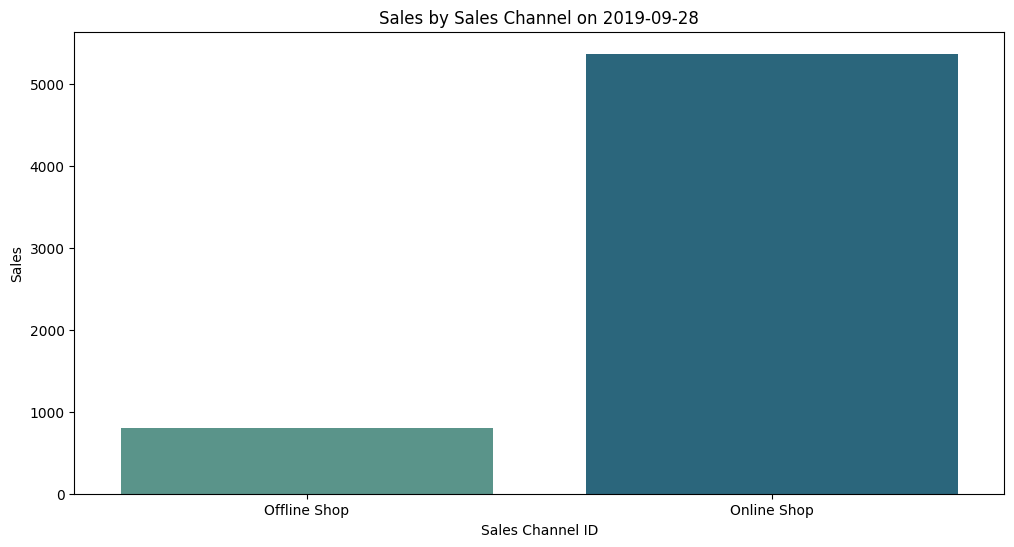

In [22]:
sep28 = trans2019[trans2019['t_dat']=='2019-09-28']
channel = sep28.groupby(by='sales_channel_id')['price'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='sales_channel_id', y='price', data=channel, palette='crest')
plt.xlabel('Sales Channel ID')
plt.xticks([0,1], ['Offline Shop', 'Online Shop'])
plt.ylabel('Sales')
plt.title('Sales by Sales Channel on 2019-09-28')

Text(0.5, 1.0, 'Customer Count by Index Group Name on 2019-09-28')

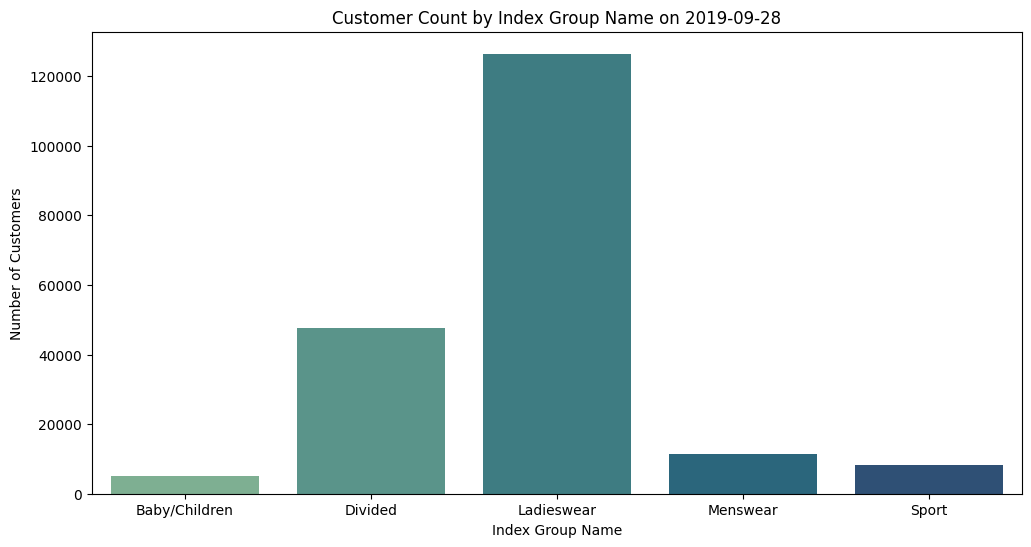

In [23]:
sep28 = trans2019[trans2019['t_dat']=='2019-09-28']
indexGroup = sep28.groupby(by='index_group_name')['customer_id'].count().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='index_group_name', y='customer_id', data=indexGroup, palette='crest')
plt.xlabel('Index Group Name')
plt.ylabel('Number of Customers')
plt.title('Customer Count by Index Group Name on 2019-09-28')

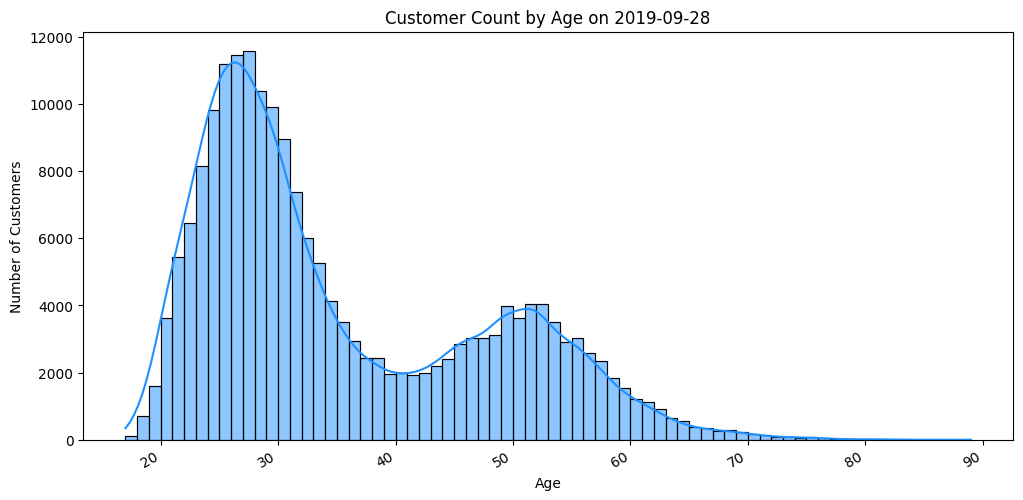

In [24]:
sep28 = trans2019[trans2019['t_dat']=='2019-09-28']
sep28 = sep28.merge(customer, on='customer_id', how='left')
plt.figure(figsize=(12, 6))
sns.histplot(data = sep28, x='age', bins=72, kde=True, color = 'dodgerblue')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.title('Customer Count by Age on 2019-09-28')
plt.gcf().autofmt_xdate()
plt.show()

### * 2019년 9월 28일은 토요일이였다. 
### * 위의 그래프들을 통해 9월 28일에 구매자들은 온라인 채널을 더 많이 사용했다는 것을 알 수 있었다.
### * 또한 여성복을 구매한 구매자가 제일 많았다.
### * 고객의 특정 연령층은 20대 중반 사이에서 30대 초반이 가장 많은 것을 알 수 있었다.
### * H&M 홈페이지 뉴스룸 페이지에서 2019년 9월 26일에 AW19 Conscious Exclusive 컬렉션을 온라인 채널에서만 판매하기 시작했다.
> * https://about.hm.com/news/general-news-2019/hm-conscious-exclusive-aw19.html
### * 이 컬렉션은 드레스를 주로 포함하고 있다. 
> * https://post.naver.com/viewer/postView.nhn?memberNo=20048415&volumeNo=25851489
### * 20대 중반 후반 여성이라면 대부분 직장을 다니고 있어서 컬렉션 발표 당일에는 정보가 별로 없어서 구매수가 높지 않았지만 주말동안 해당 컬렉션의 정보를 접해서 9월 28일에 비약적인 매출이 나왔을 것으로 예상했지만 실질적으로는 그렇지 않았다. 

## [그래프] 9월 28일의 진실

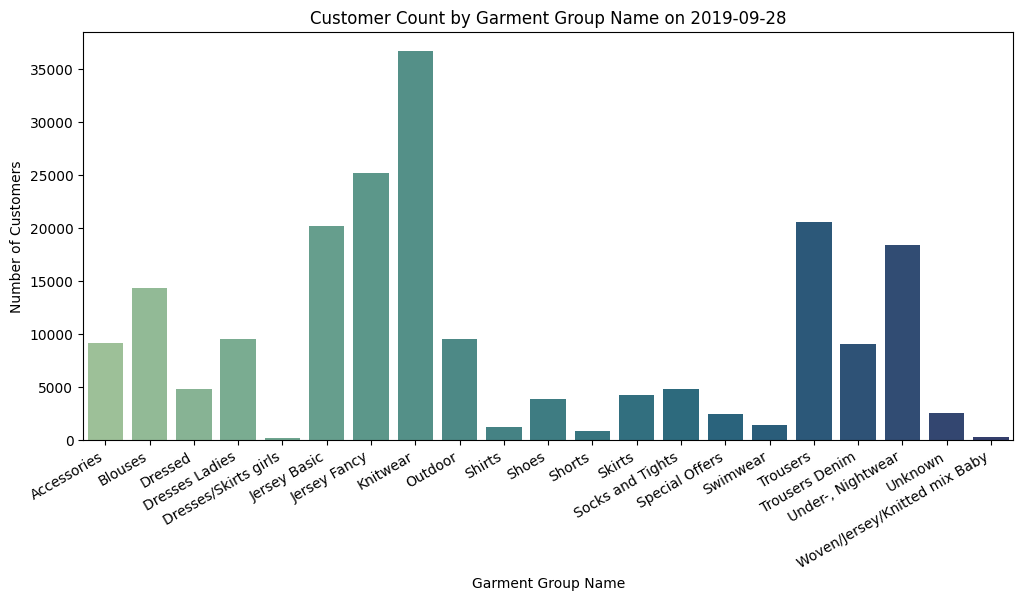

In [25]:
sep28 = trans2019[trans2019['t_dat']=='2019-09-28']
garmentGroup = sep28.groupby(by='garment_group_name')['customer_id'].count().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='garment_group_name', y='customer_id', data=garmentGroup, palette='crest')
plt.xlabel('Garment Group Name')
plt.ylabel('Number of Customers')
plt.title('Customer Count by Garment Group Name on 2019-09-28')
plt.gcf().autofmt_xdate()
plt.show()

### * 예상대로라면 Dress가 9월 28일에 가장 많은 구매가 이루어졌어야 하는데 Knitwear, Jersery Fancy, Trousers, Jersey Basic, Under- Nightwear, Blouses, Dresses Ladies 순으로 7번째로 많이 팔린 품목에 해당됐다.

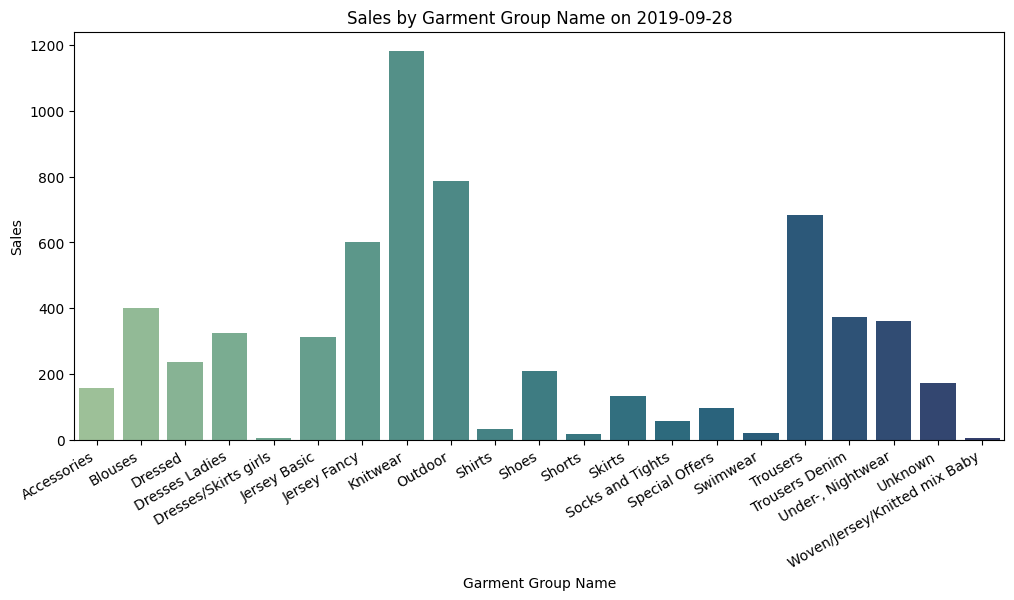

In [26]:
sep28 = trans2019[trans2019['t_dat']=='2019-09-28']
garmentGroup = sep28.groupby(by='garment_group_name')['price'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='garment_group_name', y='price', data=garmentGroup, palette='crest')
plt.xlabel('Garment Group Name')
plt.ylabel('Sales')
plt.title('Sales by Garment Group Name on 2019-09-28')
plt.gcf().autofmt_xdate()
plt.show()

### * 그래프를 통해 9월 28일에 매출을 높인 품목은 Knitwear, Outdoor, 그리고 Trouser인 것을 확인할 수 있었다.

In [27]:
sep28 = trans2019[trans2019['t_dat']=='2019-09-28']
productGroup = sep28.groupby(by='product_type_name')['price'].sum().reset_index(name='sales')
productGroup.sort_values(by='sales', ascending=False).reset_index().drop('index',axis=1).head(10)

,product_type_name,sales
0,Sweater,1155.286864
1,Trousers,1086.855644
2,Jacket,493.459966
3,Dress,491.040593
4,Coat,297.354525
5,Blouse,270.016915
6,Blazer,250.754441
7,Top,238.040729
8,Skirt,191.047441
9,Bra,171.108864


### * 매출이 많은 상품을 봤을 때, 날이 추워짐에 따라 위의 품목에 대한 매출이 늘어난것을 확인할 수 있었다.
### * 하지만 특정한 날에만 많은 매출과 구매자가 몰렸던 것으로 보아 온라인 세일 행사를 진행했기 때문에 매출이 높았던것 같다.

## [그래프] 2020년 8월 매출과 구매자 수

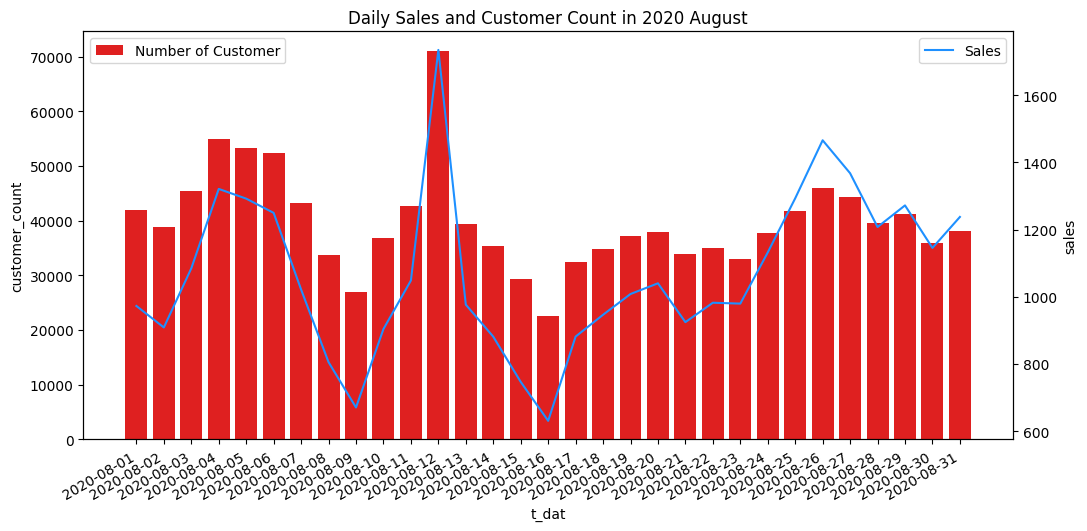

In [28]:
saleSum2020 = trans2020.groupby(by=['t_dat'])['price'].sum().reset_index(name='sales')
custCount2020 = trans2020.groupby(by=['t_dat'])['customer_id'].count().reset_index(name='customer_count')
saleCust2020 = saleSum2020.merge(custCount2020, on='t_dat', how='left')
fig, ax = plt.subplots(figsize=(12, 6))
p1 = sns.barplot(ax=ax, x='t_dat', y='customer_count', data=saleCust2020, color='red', label='Number of Customer')
ax2 = ax.twinx()
p2 = sns.lineplot(ax=ax2, x=ax.get_xticks(), y='sales', data=saleCust2020, color='dodgerblue', label='Sales')
date_range = pd.date_range(start='2020-08-01', end='2020-08-31', freq='D')
date_labels = [date.strftime('%Y-%m-%d') for date in date_range]
plt.xticks(range(31), date_labels)
p1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Daily Sales and Customer Count in 2020 August')
plt.gcf().autofmt_xdate()

### * 이 그래프를 통해서 2019년 9월과는 달리 2020년 8월은 구매가 비교적 균등하게 진행됨을 알 수 있다. 

## [데이터 전처리] 2020년 7월과 8월 비교

In [29]:
trans2020 = transactionWithName[(transactionWithName['t_dat']>'2020-06-30')&(transactionWithName['t_dat']<'2020-09-01')]
trans2020.head(3)

,t_dat,Years,Months,Days,customer_id,article_id,price,sales_channel_id,index_group_name,garment_group_name,product_type_name,prod_name
28401361,2020-07-01,2020,7,1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,825577003,0.013542,2,Ladieswear,Jersey Fancy,Dress,PIXI TSHIRT DRESS
28401362,2020-07-01,2020,7,1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,849487005,0.042356,2,Ladieswear,Blouses,Jacket,Seb overshirt
28401363,2020-07-01,2020,7,1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,772659001,0.023712,2,Ladieswear,Trousers,Shorts,Ruby shorts


Text(0.5, 1.0, 'Customer Count by Sales Channel between 2020 July and 2020 August')

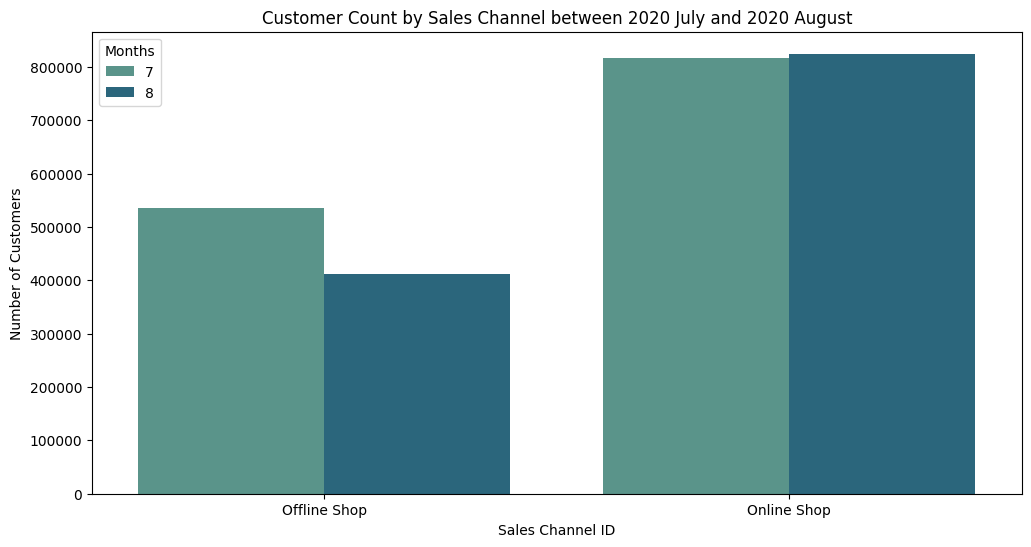

In [30]:
channel = trans2020.groupby(by=['Months','sales_channel_id'])['customer_id'].count().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='sales_channel_id', y='customer_id', hue='Months',data=channel, palette='crest')
plt.xlabel('Sales Channel ID')
plt.xticks([0,1], ['Offline Shop', 'Online Shop'])
plt.ylabel('Number of Customers')
plt.title('Customer Count by Sales Channel between 2020 July and 2020 August')

Text(0.5, 1.0, 'Customer Count by Index Group Name between 2020 July and 2020 August')

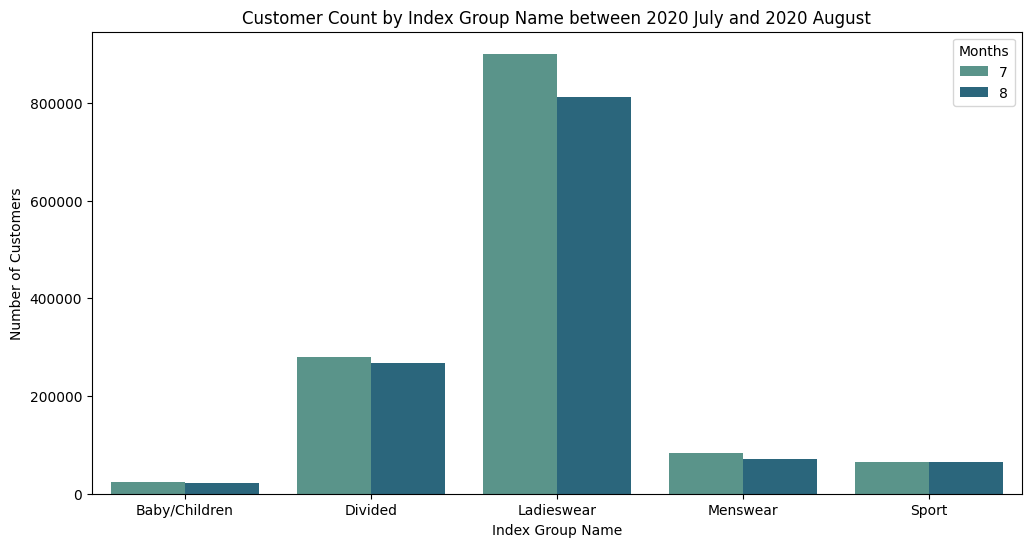

In [31]:
indexGroup = trans2020.groupby(by=['Months','index_group_name'])['customer_id'].count().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='index_group_name', y='customer_id', hue='Months', data=indexGroup, palette='crest')
plt.xlabel('Index Group Name')
plt.ylabel('Number of Customers')
plt.title('Customer Count by Index Group Name between 2020 July and 2020 August')

83.0

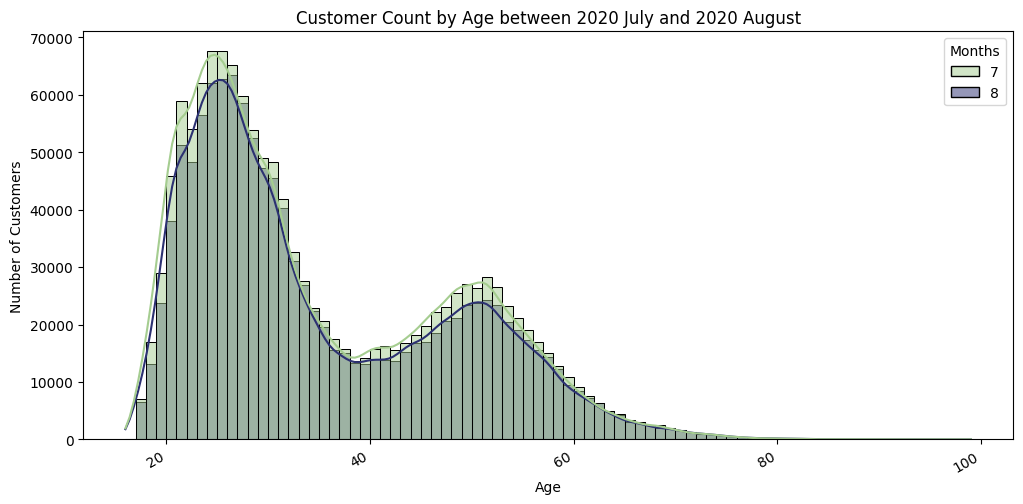

In [32]:
comparison = trans2020.merge(customer, on='customer_id', how='left')
plt.figure(figsize=(12, 6))
sns.histplot(data = comparison, x='age', hue='Months', bins=83, kde=True, palette='crest')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.title('Customer Count by Age between 2020 July and 2020 August')
plt.gcf().autofmt_xdate()
comparison['age'].max()-comparison['age'].min()

### * 8월달 온라인 채널을 통한 주문 건수가 7월달과 비교했을 때 미세하게 더 많았다. 
### * 어느 특정한 분야에서만 8월달 구매 고객의 수가 7월달에 비해 적어진 것이 아니였다.
### * 그래서 왜 8월달에 매출이 높았는가?

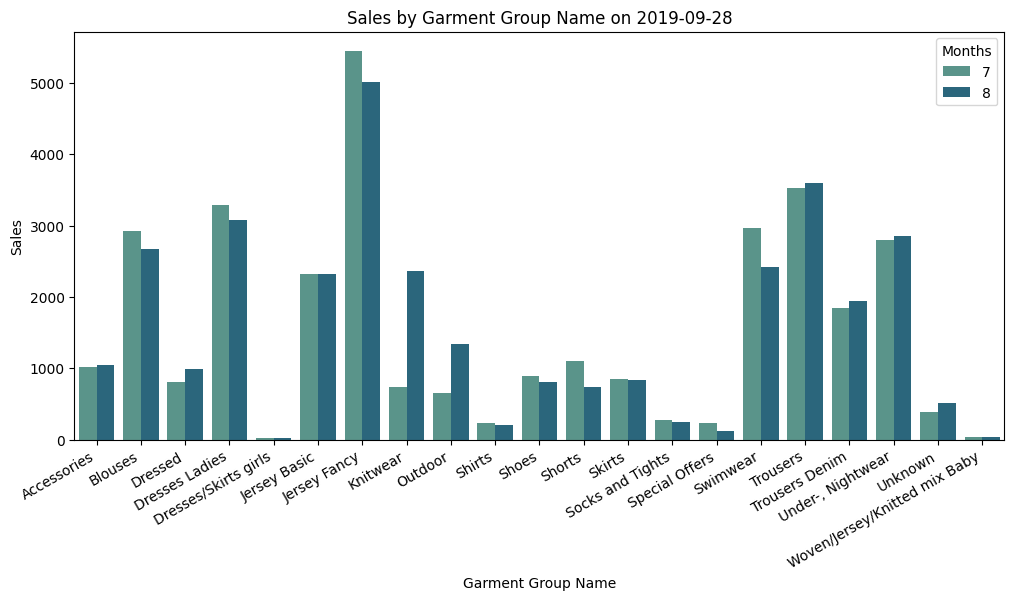

In [33]:
garmentGroup = trans2020.groupby(by=['garment_group_name', 'Months'])['price'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='garment_group_name', y='price', hue='Months', data=garmentGroup, palette='crest')
plt.xlabel('Garment Group Name')
plt.ylabel('Sales')
plt.title('Sales by Garment Group Name on 2019-09-28')
plt.gcf().autofmt_xdate()
plt.show()

In [34]:
productGroup = transactionWithName.groupby(by=['garment_group_name'])['price'].mean().reset_index(name='avg_sales_price')
productGroup = productGroup.sort_values(by=['avg_sales_price'], ascending=False).reset_index().drop('index',axis=1)
productGroup.head(10)

,garment_group_name,avg_sales_price
0,Outdoor,0.069812
1,Dressed,0.055843
2,Unknown,0.048246
3,Trousers Denim,0.040594
4,Shoes,0.038988
5,Special Offers,0.036841
6,Dresses Ladies,0.036182
7,Trousers,0.034556
8,Skirts,0.034328
9,Knitwear,0.032241


### * 그래프를 통해서 8월달에 Dressed, Knitwear, Outdoor, Trousers, Trousers Denim, under-, Nightwear, Unknown들의 매출이 더 높은 것을 알 수 있다.
### * 표를 통해서 전체 데이터에서 평균 단가가 높은 상품들이 8월에 더 많이 팔려서 매출이 8월보다 높았다는 것을 알 수 있었다. 

## [그래프] 2018년 9월 20일부터 2020년 9월 22일까지의 매출 추이

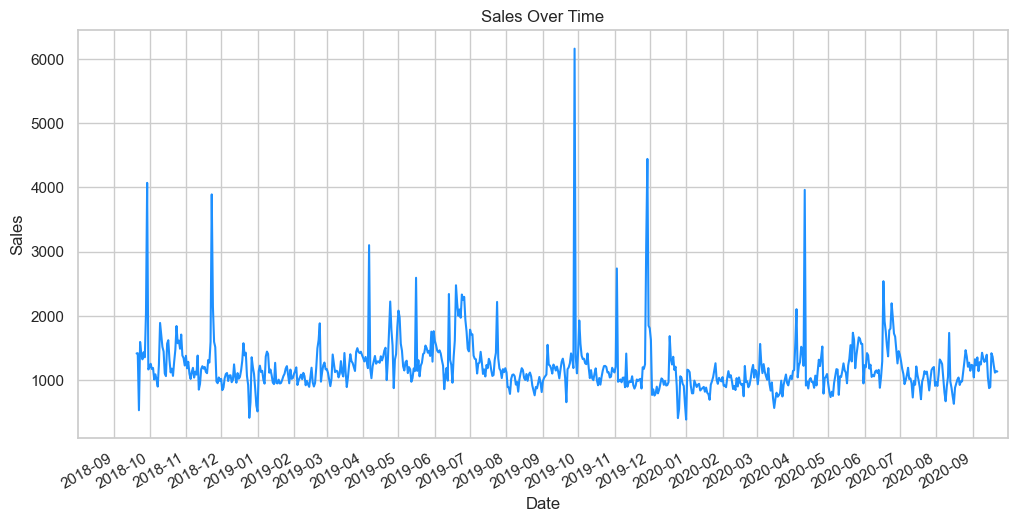

In [35]:
salesOverTime = transactionWithName.groupby(['t_dat'])['price'].sum().reset_index(name='sales')
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=salesOverTime, x='t_dat', y='sales', color='dodgerblue')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')

start_date = '2018-08'
end_date = '2020-10'
plt.xlim([pd.Timestamp(start_date), pd.Timestamp(end_date)])
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

current_ticks = plt.gca().get_xticks()
if len(current_ticks) > 2: 
    new_ticks = current_ticks[1:-1]
    plt.gca().set_xticks(new_ticks)
plt.show()

### * 만약 매출 그래프가 정상성을보인다면 미래에 매출을 예측하기 쉬워서 비즈니스 전략을 세울 때 용이할 것이다.
### * 하지만 몇몇 지점에서 일시적으로 판매가 높아서 이상치가 있는 것을 확인할 수 있다.
### * 앞서 살펴본 결과 2월부터 6월까지의 기간에 매출이 증가하고 6월을 기점으로 8월까지 매출이 하락하는 패턴이 있는 것처럼 보였다.
### * 이는 그래프가 계절성이 있다고 보여질 수 있다.
### * 그래프가 계절성을 보인다면 정상적이지 않을수 있기 때문에 Augmented Dickey-Fuller 검정을 통해 그래프의 정상성을 확인해봐야한다.

## [시계열 분석] Augmented Dickey-Fuller Test 매출

In [36]:
salesOverTime.set_index('t_dat', inplace=True)
testAdf = adfuller(salesOverTime['sales'])
print('ADF Statistic: %f' % testAdf[0])
print('p-value: %f' % testAdf[1])
print('Critical Values:')
for key, value in testAdf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.434371
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


### * ADF 테스트를 통해 ADF 통계치인 -7.43이 모든 임계값보다 작고 p-value가 매우 낮음으로 시계열이 정상적이라는 것을 알수있다.
### * 데이터가 시간에 따라 일정한 평균과 분산을 유지하며 추세나 계절성을 나타내지 않는다.
### * 이를 통해 다른 변수들과의 관계 분석이나, 원인과 결과의 관계를 탐색하기 위한 데이터로 활용이 가능하다는 것을 확인 할 수 있었다. 

### [그래프] 2018년 9월 20일부터 2020년 9월 22일까지의 소비자 수

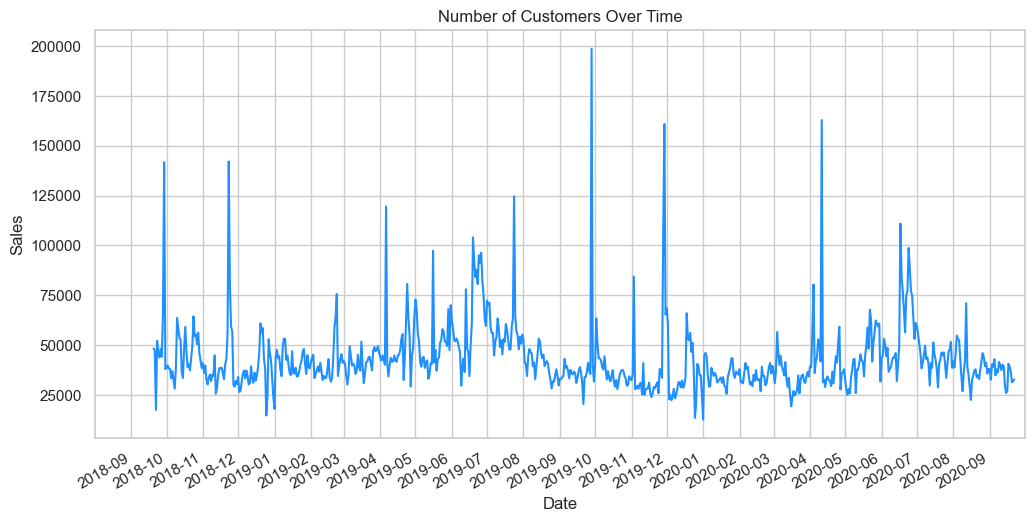

In [37]:
custOverTime = transactionWithName.groupby(['t_dat'])['customer_id'].count().reset_index(name='customer_count')
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=custOverTime, x='t_dat', y='customer_count', color='dodgerblue')
plt.title('Number of Customers Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')

start_date = '2018-08'
end_date = '2020-10'
plt.xlim([pd.Timestamp(start_date), pd.Timestamp(end_date)])
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

current_ticks = plt.gca().get_xticks()
if len(current_ticks) > 2: 
    new_ticks = current_ticks[1:-1]
    plt.gca().set_xticks(new_ticks)
plt.show()

## [시계열 분석] Augmented Dickey-Fuller Test 구매자 수

In [38]:
custOverTime.set_index('t_dat', inplace=True)
testAdf = adfuller(custOverTime['customer_count'])
print('ADF Statistic: %f' % testAdf[0])
print('p-value: %f' % testAdf[1])
print('Critical Values:')
for key, value in testAdf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.444082
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569


## [데이터 전처리] 전체 매출과 구매자 수 병합

In [39]:
custSales = pd.merge(salesOverTime, custOverTime, left_index=True, right_index=True)
custSales.head(3)

,sales,customer_count
t_dat,,
2018-09-20,1415.345847,48399
2018-09-21,1419.262305,47543
2018-09-22,530.437627,17635


## [상관관계 분석]

In [40]:
correlation, p_value = pearsonr(custSales['sales'], custSales['customer_count'])
print(f'Pearson Correlation Coefficient: {correlation}')
print(f'P-value: {p_value}')

Pearson Correlation Coefficient: 0.943816154920071
P-value: 0.0


### * 구매자 수와 매출은 상관관계가 있음을 알 수 있다.

# 3. H&M 주가와 섬유, 의류, 및 명품 산업 지수 분석

## 데이터 

### hmstock => H&M 주가 데이터

In [41]:
hmstock = yf.download('HM-B.ST', start='2018-09-20', end='2023-12-31')
hmstock.index = hmstock.index.tz_localize('UTC')
hmstock = hmstock.drop(['Open', 'High', 'Low', 'Volume', 'Close'], axis=1)
hmstock.rename(columns={'Adj Close':'hm_close'}, inplace=True)
hmstock.head(3)

[*********************100%***********************]  1 of 1 completed


,hm_close
Date,
2018-09-20 00:00:00+00:00,114.186821
2018-09-21 00:00:00+00:00,116.010986
2018-09-24 00:00:00+00:00,118.795250


### americaTextile => S&P 500 Textiles, Apparel & Luxury Goods 산업 지수 

In [42]:
americaTextile = yf.download('^SP500-252030', start='2018-09-20', end='2023-12-31')
americaTextile.index = americaTextile.index.tz_localize('UTC')
americaTextile = americaTextile.drop(['Open', 'High', 'Low', 'Volume', 'Close'], axis=1)
americaTextile.rename(columns={'Adj Close':'sp_close'}, inplace=True)
americaTextile.head(3)

[*********************100%***********************]  1 of 1 completed


,sp_close
Date,
2018-09-20 00:00:00+00:00,906.039978
2018-09-21 00:00:00+00:00,908.320007
2018-09-24 00:00:00+00:00,892.200012


### europeTextile => MSCI Europe Textiles, Apparel & Luxury Goods 산업 지수

In [43]:
europeTextile = yf.download('^106683-USD-STRD', start='2018-09-20', end='2023-12-31')
europeTextile.index = europeTextile.index.tz_localize('UTC')
europeTextile = europeTextile.drop(['Open', 'High', 'Low', 'Volume', 'Close'], axis=1)
europeTextile.rename(columns={'Adj Close':'eu_close'}, inplace=True)
europeTextile.head(3)

[*********************100%***********************]  1 of 1 completed


,eu_close
Date,
2018-09-20 00:00:00+00:00,826.880005
2018-09-21 00:00:00+00:00,840.099976
2018-09-24 00:00:00+00:00,838.450012


## [데이터 전처리] H&M 주가, 미국과 영국의 섬유, 의류, 및 명품 산업 지수 병합하기

In [44]:
mergedData = pd.merge(hmstock, americaTextile, left_index=True, right_index=True)
mergedData = pd.merge(mergedData, europeTextile, left_index=True, right_index=True)
mergedData.index = mergedData.index.tz_localize(None)
mergedData = mergedData[mergedData.index<'2020-09-23']
mergedData.info()
mergedData.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 478 entries, 2018-09-20 to 2020-09-22
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hm_close  478 non-null    float64
 1   sp_close  478 non-null    float64
 2   eu_close  478 non-null    float64
dtypes: float64(3)
memory usage: 14.9 KB


,hm_close,sp_close,eu_close
Date,,,
2018-09-20,114.186821,906.039978,826.880005
2018-09-21,116.010986,908.320007,840.099976
2018-09-24,118.795250,892.200012,838.450012


## [상관관계 분석]

In [45]:
correlation, p_value = pearsonr(mergedData['hm_close'], mergedData['sp_close'])
print(f'Pearson Correlation Coefficient: {correlation}')
print(f'P-value: {p_value}')

Pearson Correlation Coefficient: 0.586045929764237
P-value: 2.009190752704179e-45


In [46]:
correlation, p_value = pearsonr(mergedData['hm_close'], mergedData['eu_close'])
print(f'Pearson Correlation Coefficient: {correlation}')
print(f'P-value: {p_value}')

Pearson Correlation Coefficient: 0.6661320159180154
P-value: 1.3057272259956577e-62


In [47]:
correlation, p_value = pearsonr(mergedData['sp_close'], mergedData['eu_close'])
print(f'Pearson Correlation Coefficient: {correlation}')
print(f'P-value: {p_value}')

Pearson Correlation Coefficient: 0.7341119634952857
P-value: 4.7319913218877697e-82


### * H&M의 주가와 관련 산업 지수간의 상관관계를 확인할 수 있었다.
### * 이 세 주체간의 관계가 양의 상관관계를 가지며, 시장 변동이나 어떠한 영향이 이들 모두에게 비슷한 영향을 줄 수 있다고 추론할 수 있다. 

## [그래프] 주가와 관련 지수

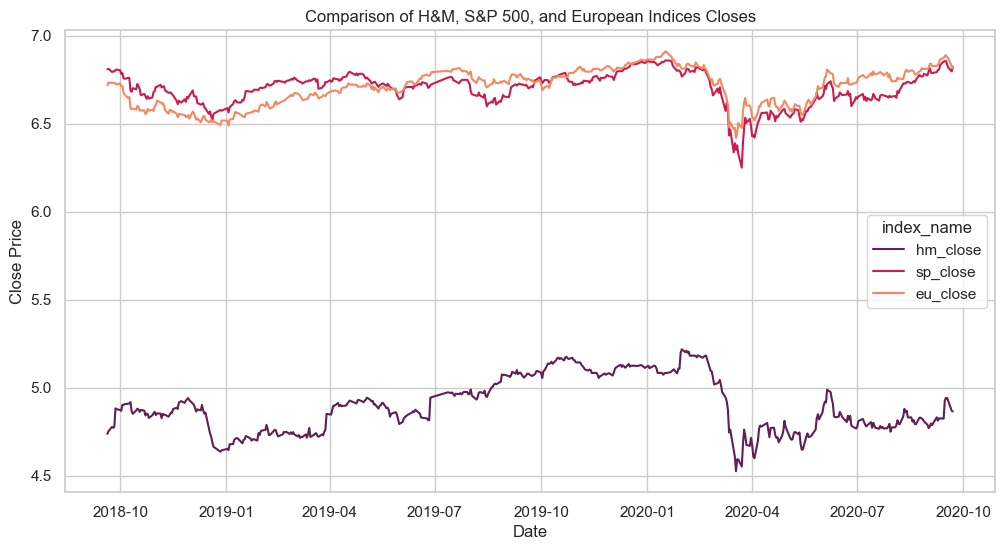

In [48]:
restructuredData = mergedData.reset_index().melt('Date', var_name='index_name', value_name='Close')
restructuredData['Close'] = np.log(restructuredData['Close'])
plt.figure(figsize=(12, 6))
sns.lineplot(data=restructuredData, x='Date', y='Close', hue='index_name', palette="rocket")
plt.title('Comparison of H&M, S&P 500, and European Indices Closes')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

### * 상관관계 분석에 이어서 그래프를 봤을 때 서로 비슷한 움직임을 보이는 것을 확인할 수 있다.

In [49]:
testAdf = adfuller(mergedData['hm_close'])
print('ADF Statistic: %f' % testAdf[0])
print('p-value: %f' % testAdf[1])
print('Critical Values:')
for key, value in testAdf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.078394
p-value: 0.253291
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570


# 4. 매출과 소비자 지수간의 연관성

## 데이터

### retailTurnOverSales => 미국과 유럽의 소매 매출액 및 지수

In [50]:
retailTurnOverSales = pd.read_csv('retail_index_and_turnover.csv', index_col='Date')
retailTurnOverSales.info()
retailTurnOverSales.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 2018-09 to 2023-12
Data columns (total 3 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   eu_retail_trade_exclude_automobile_index     64 non-null     float64
 1   eu_retail_sale_consumer_fashion_goods_index  44 non-null     float64
 2   us_retail_trade_clothing_store_sales_usdM    64 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 2.0+ KB


,eu_retail_trade_exclude_automobile_index,eu_retail_sale_consumer_fashion_goods_index,us_retail_trade_clothing_store_sales_usdM
Date,,,
2018-09,107.4,101.6,21963
2018-10,108.1,102.5,22426
2018-11,108.4,104.4,22492


## [데이터 전처리] H&M 매출 데이터 연월별로 정리

In [51]:
hmSales = transactionWithName.groupby(by=['Years','Months'])['price'].sum().reset_index(name='monthly_sales')
hmSales['Date'] = hmSales['Years'].astype(str) + '-' + hmSales['Months'].astype(str)
hmSales['Date'] = pd.to_datetime(hmSales['Date'], format='%Y-%m')
hmSales['Date'] = hmSales['Date'].dt.strftime('%Y-%m')
temp = hmSales['Date']
del hmSales['Date']
hmSales.insert(0, "Date", temp)
hmSales.set_index('Date', inplace=True)
hmSales = hmSales.drop(['Years', 'Months'],axis=1)
hmSales.info()
hmSales.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 2018-09 to 2020-09
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   monthly_sales  25 non-null     float64
dtypes: float64(1)
memory usage: 400.0+ bytes


,monthly_sales
Date,
2018-09,17755.639593
2018-10,41584.816610
2018-11,39000.988390


In [52]:
hmCust = transactionWithName.groupby(by=['Years','Months'])['customer_id'].count().reset_index(name='monthly_customers')
hmCust['Date'] = hmCust['Years'].astype(str) + '-' + hmCust['Months'].astype(str)
hmCust['Date'] = pd.to_datetime(hmCust['Date'], format='%Y-%m')
hmCust['Date'] = hmCust['Date'].dt.strftime('%Y-%m')
temp = hmCust['Date']
del hmCust['Date']
hmCust.insert(0, "Date", temp)
hmCust.set_index('Date', inplace=True)
hmCust = hmCust.drop(['Years', 'Months'],axis=1)
hmCust.info()
hmCust.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 2018-09 to 2020-09
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   monthly_customers  25 non-null     int64
dtypes: int64(1)
memory usage: 400.0+ bytes


,monthly_customers
Date,
2018-09,594776
2018-10,1397040
2018-11,1270619


## [데이터 전처리] H&M 매출과 미국 유럽의 소매 매출 및 지수 병합

In [53]:
mergedRetail = pd.merge(hmSales, retailTurnOverSales, left_index=True, right_index=True)
# mergedRetail = pd.merge(mergedRetail, retailTurnOverSales, left_index=True, right_index=True)
mergedRetail = mergedRetail[mergedRetail.index<'2020-10']
mergedRetail.info()
mergedRetail.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 2018-09 to 2020-09
Data columns (total 4 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   monthly_sales                                25 non-null     float64
 1   eu_retail_trade_exclude_automobile_index     25 non-null     float64
 2   eu_retail_sale_consumer_fashion_goods_index  25 non-null     float64
 3   us_retail_trade_clothing_store_sales_usdM    25 non-null     int64  
dtypes: float64(3), int64(1)
memory usage: 1000.0+ bytes


,monthly_sales,eu_retail_trade_exclude_automobile_index,eu_retail_sale_consumer_fashion_goods_index,us_retail_trade_clothing_store_sales_usdM
Date,,,,
2018-09,17755.639593,107.4,101.6,21963
2018-10,41584.816610,108.1,102.5,22426
2018-11,39000.988390,108.4,104.4,22492


## [상관관계 분석]

In [54]:
print('Correlation between H&M Sales and eu_retail_trade_exclude_automobile_index')
correlation, p_value = pearsonr(mergedRetail['monthly_sales'], mergedRetail['eu_retail_trade_exclude_automobile_index'])
print(f'Pearson Correlation Coefficient: {correlation}')
print(f'P-value: {p_value}')
print('Correlation between H&M Sales and eu_retail_sale_consumer_fashion_goods_index')
correlation, p_value = pearsonr(mergedRetail['monthly_sales'], mergedRetail['eu_retail_sale_consumer_fashion_goods_index'])
print(f'Pearson Correlation Coefficient: {correlation}')
print(f'P-value: {p_value}')
print('Correlation between H&M Sales and us_retail_trade_clothing_store_sales_usdM')
correlation, p_value = pearsonr(mergedRetail['monthly_sales'], mergedRetail['us_retail_trade_clothing_store_sales_usdM'])
print(f'Pearson Correlation Coefficient: {correlation}')
print(f'P-value: {p_value}')

Correlation between H&M Sales and eu_retail_trade_exclude_automobile_index
Pearson Correlation Coefficient: -0.04852154650896144
P-value: 0.8178412211184395
Correlation between H&M Sales and eu_retail_sale_consumer_fashion_goods_index
Pearson Correlation Coefficient: 0.023844612502233586
P-value: 0.9099235122657341
Correlation between H&M Sales and us_retail_trade_clothing_store_sales_usdM
Pearson Correlation Coefficient: -0.02623833370703329
P-value: 0.9009224064538938


### * 미국과 유럽의 소매 매출과 지수와 관계가 없다는 것을 알 수 있었다.
### * H&M의 주 매출 시장은 유럽과 북아메리카이지만 비교적 더 많은 비중을 차지하는 유럽에서 상관관계가 없다는 것이 조금 의아했다.

## [그래프] H&M 구매자 수와 매출과 미국과 유럽의 매출 및 지수

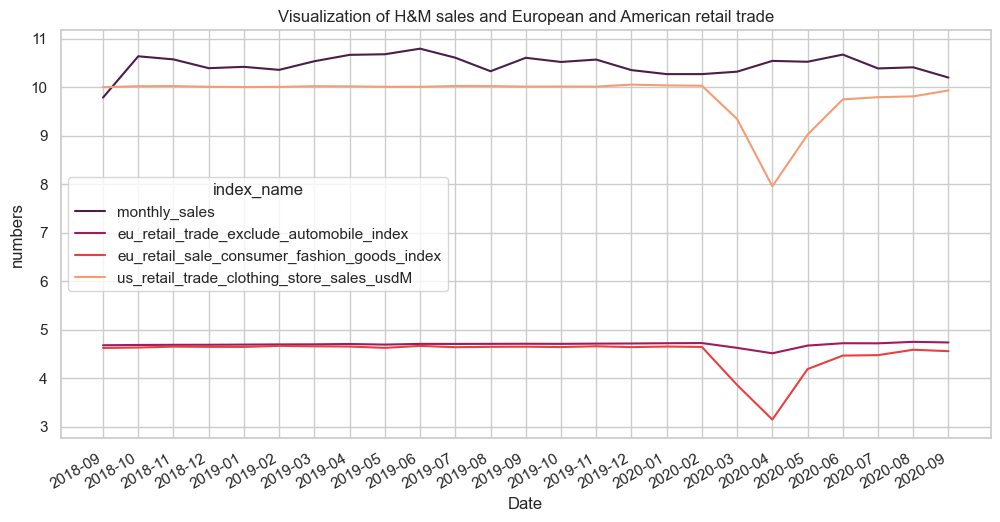

In [55]:
mergedRetail = mergedRetail.reset_index().melt('Date', var_name='index_name', value_name='numbers')
mergedRetail['numbers'] = np.log(mergedRetail['numbers'])
plt.figure(figsize=(12, 6))
sns.lineplot(data=mergedRetail, x='Date', y='numbers', hue='index_name', palette="rocket")
plt.title('Visualization of H&M sales and European and American retail trade')
plt.xlabel('Date')
plt.ylabel('numbers')
plt.gcf().autofmt_xdate()
plt.show()

### * 모든 지수가 2020년 2월 전까지는 일정하지만 이후부터 많은 차이가 있는 것을 알 수 있다.
### * 2020년 2월부터 4월까지 유럽의 종합 소매 매출보다 유럽과 미국의 패션 소매 매출이 코로나로 인해 많은 영향을 받았다.
### * 하지만 H&M 구매자 수와 매출은 해당 기간에 미세하게 상승한것으로 보인다.
### * 해당 기간 동안 어느 부분이 많이 판매됐는지 살펴봐야 할것 같다.

## [데이터 전처리] 2020년 2월부터 4월까지 어느 상품이 많이 판매됐는지 살펴보고 이유 추측해보기

In [56]:
hmData = transactionWithName[(transactionWithName['t_dat']>'2020-01-31')&(transactionWithName['t_dat']<'2020-05-01')]
hmData.info()
hmData.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3390493 entries, 21884546 to 25275038
Data columns (total 12 columns):
 #   Column              Dtype         
---  ------              -----         
 0   t_dat               datetime64[ns]
 1   Years               int64         
 2   Months              int64         
 3   Days                int64         
 4   customer_id         object        
 5   article_id          int64         
 6   price               float64       
 7   sales_channel_id    int64         
 8   index_group_name    object        
 9   garment_group_name  object        
 10  product_type_name   object        
 11  prod_name           object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 336.3+ MB


,t_dat,Years,Months,Days,customer_id,article_id,price,sales_channel_id,index_group_name,garment_group_name,product_type_name,prod_name
21884546,2020-02-01,2020,2,1,00023e3dd8618bc63ccad995a5ac62e21177338d642d66...,843200001,0.054220,2,Ladieswear,Outdoor,Blazer,ED Cassis blazer
21884547,2020-02-01,2020,2,1,00023e3dd8618bc63ccad995a5ac62e21177338d642d66...,830487001,0.033881,2,Ladieswear,Jersey Fancy,Trousers,ED Ferrari trouser
21884548,2020-02-01,2020,2,1,0006d3ff0caf0cb4d4e0615ee5cb7d268622364d483335...,811777002,0.059305,2,Ladieswear,Swimwear,Swimsuit,Greece Shape Swimsuit


## [그래프] 월별 채널 이용자 수

,Months,sales_channel_id,customer_id
0,2,1,324660
1,2,2,677199
2,3,1,154087
3,3,2,893665
4,4,2,1340882


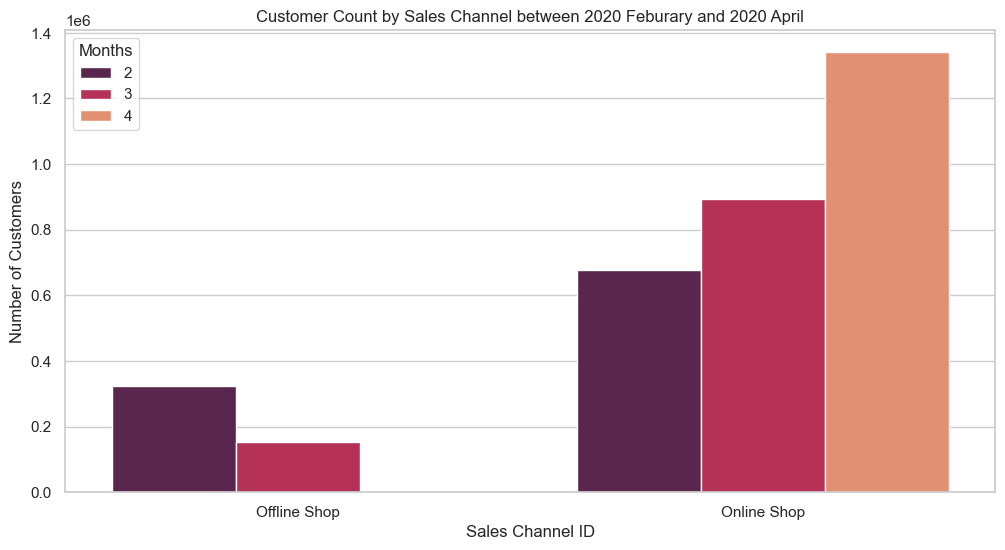

In [57]:
channel = hmData.groupby(by=['Months','sales_channel_id'])['customer_id'].count().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='sales_channel_id', y='customer_id', hue='Months',data=channel, palette='rocket')
plt.xlabel('Sales Channel ID')
plt.xticks([0,1], ['Offline Shop', 'Online Shop'])
plt.ylabel('Number of Customers')
plt.title('Customer Count by Sales Channel between 2020 Feburary and 2020 April')
channel

## [표] 채널별 월별 매출

In [58]:
channel = hmData.groupby(by=['Months','sales_channel_id'])['price'].sum().reset_index()
channel

,Months,sales_channel_id,price
0,2,1,7691.350458
1,2,2,21101.526356
2,3,1,3808.640356
3,3,2,26465.564305
4,4,2,37808.485661


## [그래프] 월별 성별 매출

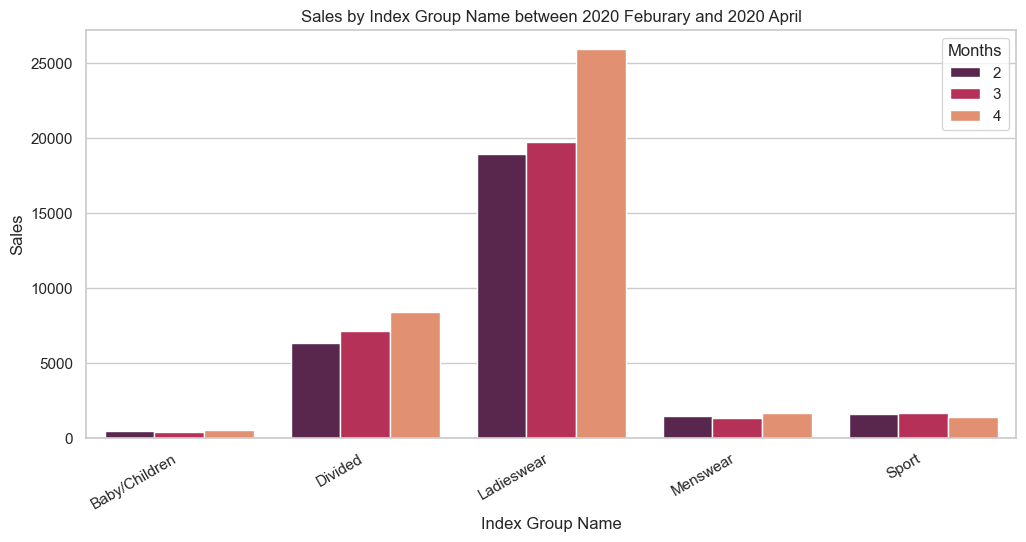

In [59]:
garmentGroup = hmData.groupby(by=['index_group_name', 'Months'])['price'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='index_group_name', y='price', hue='Months', data=garmentGroup, palette='rocket')
plt.xlabel('Index Group Name')
plt.ylabel('Sales')
plt.title('Sales by Index Group Name between 2020 Feburary and 2020 April')
plt.gcf().autofmt_xdate()
plt.show()

## [그래프] 월별 월별 매출

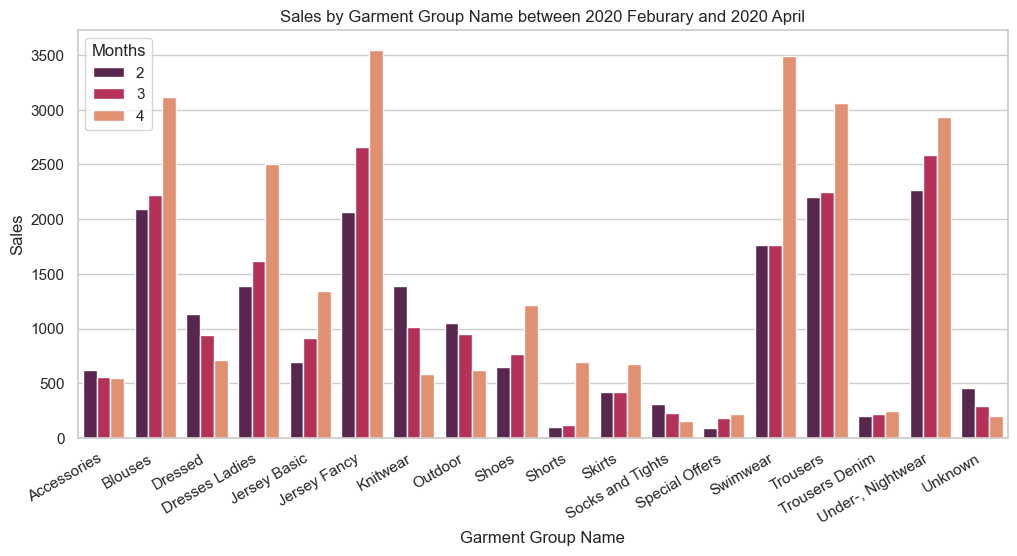

In [60]:
garmentGroup = hmData.groupby(by=['index_group_name','garment_group_name', 'Months'])['price'].sum().reset_index()
garmentGroup = garmentGroup[garmentGroup['index_group_name']=='Ladieswear']
plt.figure(figsize=(12, 6))
sns.barplot(x='garment_group_name', y='price', hue='Months', data=garmentGroup, palette='rocket')
plt.xlabel('Garment Group Name')
plt.ylabel('Sales')
plt.title('Sales by Garment Group Name between 2020 Feburary and 2020 April')
plt.gcf().autofmt_xdate()
plt.show()

## [표] 4월 평균 매출 이상 품목

In [61]:
productGroup = hmData.groupby(by=['index_group_name','product_type_name', 'Months'])['price'].sum().reset_index()
productGroup = productGroup[productGroup['index_group_name']=='Ladieswear']
a = productGroup[productGroup['Months']==4]
totalPrice = a['price'].sum()
avgPrice = a['price'].mean()
a['price_pct'] = (a['price']/totalPrice)*100
a['above_avg_sale'] = ['Above' if x > avgPrice else 'Below' for x in a['price']]
a[a['above_avg_sale']=='Above'].sort_values(by=['price_pct'], ascending=False).head(30).reset_index(drop=True)

C:\Users\regan\AppData\Local\Temp\ipykernel_17740\1219323837.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['price_pct'] = (a['price']/totalPrice)*100
C:\Users\regan\AppData\Local\Temp\ipykernel_17740\1219323837.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['above_avg_sale'] = ['Above' if x > avgPrice else 'Below' for x in a['price']]


,index_group_name,product_type_name,Months,price,price_pct,above_avg_sale
0,Ladieswear,Dress,4,4761.596915,18.391341,Above
1,Ladieswear,Trousers,4,3497.719983,13.509703,Above
2,Ladieswear,Bikini top,4,1725.505746,6.664647,Above
3,Ladieswear,Blouse,4,1434.050441,5.538921,Above
4,Ladieswear,Bra,4,1404.784085,5.425882,Above
5,Ladieswear,Swimwear bottom,4,1133.749034,4.379028,Above
6,Ladieswear,Skirt,4,1011.657559,3.907458,Above
7,Ladieswear,Vest top,4,1010.164068,3.901689,Above
8,Ladieswear,Top,4,953.342068,3.682218,Above
9,Ladieswear,T-shirt,4,889.136102,3.434227,Above


### * 월별 채널 이용자 수 그래프를 통해서 코로나로 인해 3월에 오프라인 고객이 전월 대비 52.54% 줄어들고 4월에는 아예 아무도 이용하지 않은 것을 확인할 수 있었다.
### * 그래서 4월에는 전월 대비 50.04%이나 온라인 고객이 더 많아졌고 그에 따라 온라인 매출도 전월대비 42.86% 상승했다.
### * 매출 증가 이유를 성별로 바라 보았을 때 상승 이유는 다른 품목들 보다도 여성복의 매출이 전월대비 31.21% 상승한 것을 알 수있다.
### * 여성복 매출 상승에 대한 이유를 알아보기 위해 조금 더 상세한 품목으로 매출을 살펴 보았다.
### * Blouses, Dresses Ladies, Jersey Basic, shoes, swimwear 등이 있지만 어떠한 이유로 매출이 증가했는지 알수가 없다.
### * 그래서 더 세분화된 카테고리로 살펴보고 4월 평균 매출보다 높은 항목들을 살펴보았다.
### * 살펴본 결과 캐주얼한 의류가 매출이 많은것으로 보아, 원격근무가 시작함에 따라서 해당 종류의 옷의 대한 수요가 높아진것 같다.
### * 이로 인해 2020년 2월과 4월 사이의 H&M 매출은 패션 소매 관련 지수가 급격하게 하락해도 미세하게 상승 할 수 있었던 것으로 보인다. 

# 5. 매출과 주가의 연관성

앞에서 본 상관관계를 통해 매출과 주가의 연관성은 없다고 알 수 있었다. 그렇다면 어떤 방법이 좋을까?

## [데이터 전처리] 주식가격과 매출액 병합

In [62]:
# 일별 매출 구하기
dailySales = transactionWithName.groupby(['t_dat'])['price'].sum().reset_index(name='sales')
dailySales.set_index('t_dat', inplace=True)
dailySales.rename_axis("Date", axis='index', inplace=True)
dailySales.index = dailySales.index.tz_localize('UTC')
# 주식 가격과 매출액 병합하기
hstock = hmstock.copy()
salesStock = pd.merge(dailySales, hstock, left_index=True, right_index=True)
salesStock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 499 entries, 2018-09-20 00:00:00+00:00 to 2020-09-22 00:00:00+00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     499 non-null    float64
 1   hm_close  499 non-null    float64
dtypes: float64(2)
memory usage: 11.7 KB


### * 주식 가격은 주말동안 변동되지 않는다. 하지만 매출을 주말에도 계속된다.
### * 그렇기 때문에 결측치는 제거하겠다. 

## [데이터 전처리] 결측치 제거 및 로그 정규화

In [63]:
salesStock['sales'] = np.log(salesStock['sales'])
salesStock['hm_close'] = np.log(salesStock['hm_close'])
salesStock

,sales,hm_close
Date,,
2018-09-20 00:00:00+00:00,7.255129,4.737836
2018-09-21 00:00:00+00:00,7.257893,4.753685
2018-09-24 00:00:00+00:00,7.249648,4.777401
2018-09-25 00:00:00+00:00,7.187566,4.772405
2018-09-26 00:00:00+00:00,7.268366,4.777401
...,...,...
2020-09-16 00:00:00+00:00,6.791458,4.941777
2020-09-17 00:00:00+00:00,7.257198,4.941777
2020-09-18 00:00:00+00:00,7.218073,4.924817


## [상관관계 분석] 매출과 주가

In [64]:
print('Correlation between H&M Sales and eu_retail_trade_exclude_automobile_index')
correlation, p_value = pearsonr(salesStock['sales'], salesStock['hm_close'])
print(f'Pearson Correlation Coefficient: {correlation}')
print(f'P-value: {p_value}')

Correlation between H&M Sales and eu_retail_trade_exclude_automobile_index
Pearson Correlation Coefficient: -0.0888704182269233
P-value: 0.04723761950318953


## [그래프] 매출과 주가

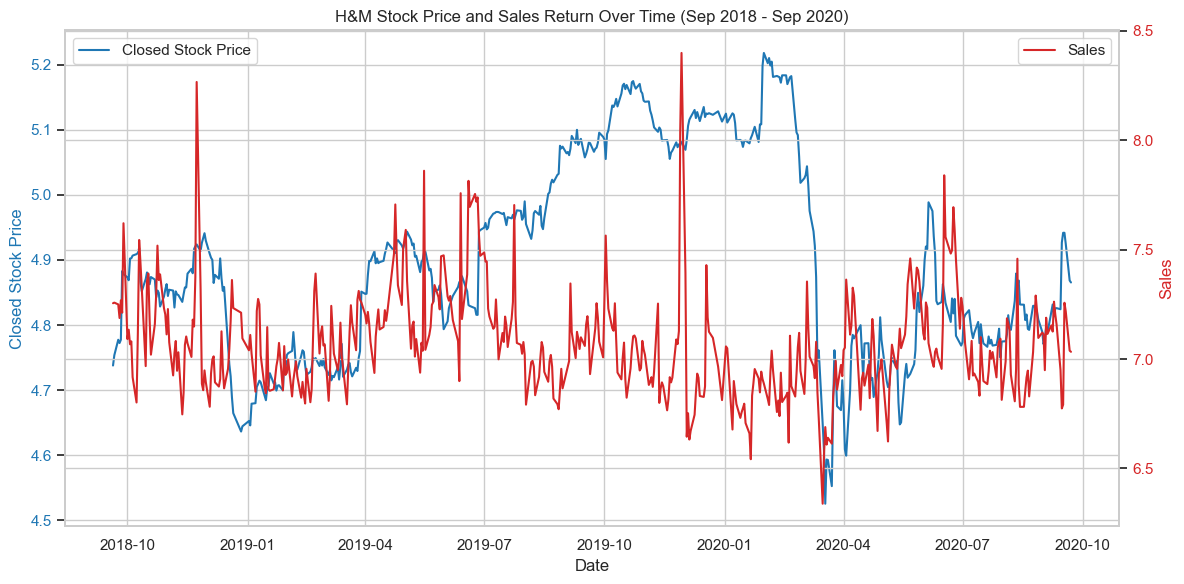

In [65]:
fig, ax = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax.set_xlabel('Date')
ax.set_ylabel('Closed Stock Price', color=color)
sns.lineplot(data=salesStock['hm_close'], ax=ax, color=color, label='Closed Stock Price')
ax.tick_params(axis='y', labelcolor=color)
plt.legend(loc='upper left')
ax2 = ax.twinx()  

color = 'tab:red'
ax2.set_ylabel('Sales', color=color) 
sns.lineplot(data=salesStock['sales'], ax=ax2, color=color, label='Sales')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')
# Title and other customizations
plt.title('H&M Stock Price and Sales Return Over Time (Sep 2018 - Sep 2020)')
fig.tight_layout()
plt.show()

## [코인테그레이션 테스트] 전체 매출과 주가

In [66]:
# Cointegration Test
pair1 = salesStock['sales']
pair2 = salesStock['hm_close']
score, p_value, critical_values = coint(pair1, pair2)
print("2018 - 2020 score: ", score)
print("2018 - 2020 p-value: ", p_value)
print("2018 - 2020 critical_values: ", critical_values)

2018 - 2020 score:  -2.827328407495346
2018 - 2020 p-value:  0.15714412798039362
2018 - 2020 critical_values:  [-3.91856695 -3.34842679 -3.05297743]


### * 확인결과 2018년부터 2020년까지 두 시계열 데이터 간의 장기적인 균형 관계가 존재하지 않았다.
### * 이는 코로나로 인한 주가의 급하락에서 비롯된것으로 보여서 연도별로 나누어 테스트를 했다. 

## [코인테그레이션 테스트] 연도별 전체 매출과 주가

In [67]:
# Cointegration Test by Years
df2018 = salesStock[salesStock.index<'2019-01-01']
df2019 = salesStock[(salesStock.index>'2018-12-31') & (salesStock.index<'2020-01-01')]
df2020 = salesStock[salesStock.index>'2019-12-31']
# Cointegration Test 2018
pair1 = df2018['sales']
pair2 = df2018['hm_close']
score, p_value, critical_values = coint(pair1, pair2)
print("2018 score: ", score)
print("2018 p-value: ", p_value)
print("2018 critical_values: ", critical_values)
# Cointegration Test 2019
pair1 = df2019['sales']
pair2 = df2019['hm_close']
score, p_value, critical_values = coint(pair1, pair2)
print("2019 score: ", score)
print("2019 p-value: ", p_value)
print("2019 critical_values: ", critical_values)
# Cointegration Test 2020
pair1 = df2020['sales']
pair2 = df2020['hm_close']
score, p_value, critical_values = coint(pair1, pair2)
print("2020 score: ", score)
print("2020 p-value: ", p_value)
print("2020 critical_values: ", critical_values)

2018 score:  -4.635083041264623
2018 p-value:  0.0007282606703349903
2018 critical_values:  [-4.064748   -3.42745997 -3.10740882]
2019 score:  -7.004548013282152
2019 p-value:  8.37074163174941e-09
2019 critical_values:  [-3.94151394 -3.36108055 -3.0617356 ]
2020 score:  -3.050914417378219
2020 p-value:  0.09859332536163395
2020 critical_values:  [-3.95762744 -3.36990796 -3.06783541]


### * 이를 통해 2018년과 2019년에는 장기적으로 매출변화와 주가 변화가 안정적인 관계에 있었지만 코로나 이후로는 더 이상 매출 증가에 따른 주가 상승 현상이 보이지 않음을 시사한다.